In [1]:
import numpy as np
import scipy.io.wavfile as wavfile

import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.silence import split_on_silence

from sklearn.decomposition import FastICA, PCA

/usr/local/lib/python3.5/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Util functions

In [31]:
def sound_to_features_matrix(sound):
    """Creates a Matrix of features from a sound
    splitted into several chunks.
    
    Parameters
    ----------
    
    sound:
        List of audio chunks.
    
    """
    
    nb_chunk = len(sound)
    nb_freq = len(sound[0])
    X = np.zeros((nb_chunk, nb_freq))
    for c in range(0, nb_chunk):
        X[c] = np.array(sound[c])
    return X

def save_samples(S, rate):
    """Saves a matrix containing several channel of audio content
    into the disk.
    
    Parameters
    ----------
    
    S:
        Matrix containing audio channels.
        
    rate:
        Audio file rate.
    
    """
    
    nb_chunk = S.shape[0]
    try:
        for i in range(0, nb_chunk):
            wavfile.write('generated_{}.wav'.format(i), rate, S[i])
    except:
        print('Failed to write samples to disk.')

# Reverse music sampling

Goal of this project: find the samples used to generate a music using ICA.

Through this TP, I will try several approach and see which one give the best results.

## 1. Load the data
Take a look at scipy.io.wavfile.read

In [32]:
def load_sounds(files):
    sounds = []
    for sound_path in files:
        
        obj = AudioSegment.from_wav(sound_path)
        sound_object = {
            "object": obj,
            "data": obj.get_array_of_samples(),
            "rate": obj.frame_rate
        }    
        
        sounds.append(sound_object)
        
    return sounds

In [33]:
sound_files = [ "parade.wav" ]

sounds = load_sounds(sound_files)
nb_sound = len(sounds)

print("Number of sounds: {}".format(nb_sound))

Number of sounds: 1


## 2. Sample the data
You have to cut the music into small chunks. Several strategies are possible for this task, find the best one!

In [34]:
def split_with_pydub(sound, min_silence=1000):
    """Splits a sound into several chunks by finding
    some "silent" delimiters.
    
    The silence are searched using the PyDub library.
    
    Parameters
    ----------
    
    sound:
        Sound containing one audio channel.
        
    min_silence:
        Minimum time in ms for a silence.
    
    """
    
    split = split_on_silence(sound, min_silence_len=min_silence)
    chunks = []
    for i in range(0, len(split)):
        chunks.append(split[i].get_array_of_samples())

    return chunks

In [35]:
def split_uniformly(sound, interval):
    """Splits a sound into several chunks of equal size.
    
    Parameters
    ----------
    
    sound:
        Sound containing one audio channel.
        
    interval:
        Time, in seconds, between each segment.
    
    """
    
    data = sound["data"]
    rate = sound["rate"]
    
    interval_size =  interval * rate
    
    max_offset = len(data) - interval_size
    offset = 0
    
    chunks = []
    while offset < max_offset:
        chunks.append(data[offset:offset + interval_size])
        offset += interval_size
    
    return chunks

In [7]:
def pad_chunk(sound, split_type="Left"):
    """Pads every chunks of a list of chunks, by selecting
    the one with the largest size as default value.
    
    This function is only used when splitting on silences.
    
    Parameters
    ----------
    
    sound:
        List of audio chunks.
        
    split_type:
        - 'Left': Chunks will be padded on left.
        - 'Right': Chunks will be padded on right.
        - 'Center': Chunks will be padded on left and right uniformly.
    
    """
    
    # Length of the greatest chunk ever
    max_len = 0
    
    """
        Finds the largest chunk, this is used o add padding
        to all other chunks.
        
        This loop will also convert every chunk to a numpy array,
        in order to simplify their modification.
    """ 
    nb_chunks = len(sound)
    for c in range(0, nb_chunks):
        chunk_len = len(sound[c])
        max_len = chunk_len if chunk_len > max_len else max_len
    
    """
        We can now pad all the chunks with this padding.
    """
    
    chunks = []
    for c in range(0, nb_chunks):
        a = sound[c].tolist()
        chunk_size = len(a)
        zeros = np.zeros(max_len)
        if split_type == "Left":
            start = max_len - chunk_size
            zeros[start:] = a
        elif split_type == "Center":
            start = (int)(max_len * 0.5) - (int)(chunk_size * 0.5)
            zeros[start:start + chunk_size] = a
        elif split_type == "Right":
            zeros[0:chunk_size] = a
            
        chunks.append(zeros)
    
    return chunks

## 3. Run an ICA
Run an ICA on your samples and listen to the result. Does it make sense?

In [48]:
def ica(sound, nb_comp=None, print_data=True):
    """Runs an ICA on a given chunks list.
    
    This function can be used with whatever splitting function you used.
    
    Parameters
    ----------
    
    sound:
        List of audio chunks.
        
    nb_comp:
        Number of components to ask for.
        If this parameter is not provided,
        the number of chunks will be used by default.
        
    print_data:
        If **True**, plots the chunks. 
    
    """
    
    
    X = sound_to_features_matrix(sound)
    nb_chunks = X.shape[0]
    if not(nb_comp is None):
        nb_chunks = nb_comp
    
    ica = FastICA(n_components=nb_chunks, tol=0.01, max_iter=500)
    S = ica.fit_transform(X.T)
    S = S.T
    
    if print_data:
        plt.title("{} samples unmixed".format(nb_chunks))
        for i in range(0, nb_chunks):
            plt.plot(S[i], label="sample {}".format(i), alpha=0.5)
        plt.legend()
        plt.show()
    
    return S

### Function to compare different techniques

In [49]:
def run(sound_object, data):
    """Profiling function working in several steps:
    
    1) Splits the chunks according to the splitting type
    provided in the `data' parameter.
    
    2) Runs an ICA on the chunks.
    
    3) Saves the extracted audio channels,
    only if specified in the `data' parameter
    
    This function is only used when splitting on silences.
    
    Parameters
    ----------
    
    sound:
        List of audio chunks.
        
    split_type:
        - 'Left': Chunks will be padded on left.
        - 'Right': Chunks will be padded on right.
        - 'Center': Chunks will be padded on left and right uniformly.
    
    """
    
    
    sound_obj = sound_object["object"]
    sound = sound_object["data"]
    rate = sound_object["rate"]
    
    #run_type = "Uniform" if not("run_type" in data) else data["run_type"]
    run_type = data.get("run_type", "Uniform") 
    #nb_comp = len(sound) if not("nb_comp" in data) else data["nb_comp"]
    nb_comp = data.get("nb_comp", len(sound))
    
    # Displays information about the current run.
    print("Number of desired components: {}".format(nb_comp))
    
    
    chunks = None
    if run_type == "Silent":
        #pad_type = "Left" if not("pad_type" in data) else data["pad_type"]
        pad_type = data.get("pad_type", "Left")
        chunks = split_with_pydub(sound_obj)
        chunks = pad_chunk(chunks, pad_type)
    elif run_type == "Uniform":
        interval_time = data.get("interval_time", 1)
        chunks = split_uniformly(sound_object, interval_time)
    else:
        raise ValueError("Unknown splitting method.")

    #plot = True if not("plot" in data) else data["plot"]
    #save = False if not("save" in data) else data["save"]
    plot = data.get("plot", True)
    save = data.get("save", False)
        
    S = ica(chunks, nb_comp, plot)
    if save:
        save_samples(S, rate)

### Test 1: Split on silence

We have a problem here, if we cut the sample in a non-uniform way, we will obtain samples with different size, which is a problem for the ICA.

We will try to add padding to see if it helps.

### Chunks splitted on silence

Number of desired components: 5


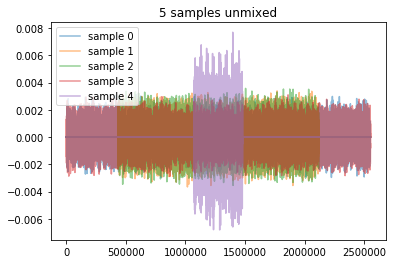

In [53]:
#S = ica(processed_sounds[0], 6, True)
data = {
    "plot": True,
    "run_type": "Silent",
    "pad_type": "Center",
    "save": True,
    "nb_comp": 5
}
run(sounds[0], data)

* Analysis

By listening at the different audio channels,
we can clearly see that splitting on **silence** was, unfortunately, 
a **bad** idea.

This does not work for several reasons:
* Silence may cut the sound at the wrong place. Even worse, it may only cut the sound when there are no voices, no instruments.
* I padded the chunks with zeros, which clearly introduces wrong data. It would have been better to simply change the speed of the chunks.

### Chunks splitted uniformly

#### 1 second interval

Number of desired components: 5


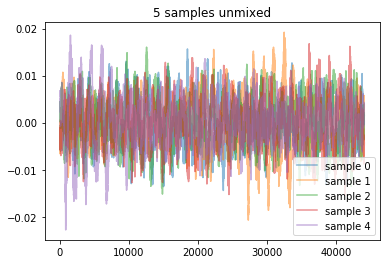

In [50]:
data = {
    "plot": True,
    "run_type": "Uniform",
    "pad_type": "Center",
    "interval_time": 1,
    "save": True,
    "nb_comp": 5
}
run(sounds[0], data)

* Analysis

This give better result to isolate the background instruments. However, specifying an interval as short as this one (only **one** second) prevent us from having more isolated data.

Let's try with a bigger interval!

#### 15 second interval

Number of desired components: 5


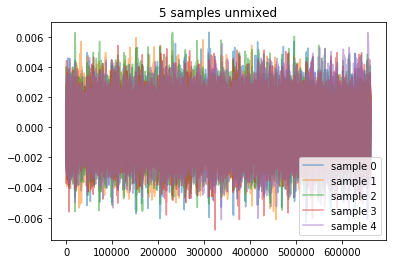

In [51]:
data = {
    "plot": True,
    "run_type": "Uniform",
    "pad_type": "Center",
    "interval_time": 15,
    "save": True,
    "nb_comp": 5
}
run(sounds[0], data)

* Analysis

This time, it clearly works better. We can isolate the drums from the reste.
We still canno't isolate the voices, but I do not know really why...

Let's test with a bigger window! (again!)

#### 30 second interval

Number of desired components: 6


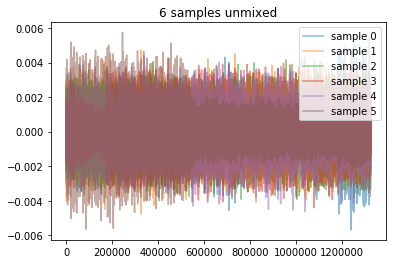

In [52]:
data = {
    "plot": True,
    "run_type": "Uniform",
    "pad_type": "Center",
    "interval_time": 30,
    "save": True,
    "nb_comp": 6
}
run(sounds[0], data)

* Analysis

Actually, with a 30 seconds interval, results are clearly better. We can find the voice, the drums, and the other instruments. Even if some parts are still mixed, the result is clearly better than using the split on silence.

## 4. Validate your results
Find a metric to evaluate your method and try to improve it.

According to the above results, when looking at the graphs and listening to the generated sounds, we can conclude that the **best** (only among what we tested here) method is the 30 seconds split. It clearly gave the best results considering pure audio channel break-up.

However, it is still *bad*, firstly because we have to test a lot of different intervals, and these intervals will depend on the processed sound.

I did not have time to dig more to find something better,
I found this paper: https://hal.inria.fr/inria-00544949/document
which I started to read but I unfortunately do not have more time to spend on the project (11 other projects are waiting for me).